<a href="https://colab.research.google.com/github/renatopaschoalim/Machine_Learning_Previsao_Demanda/blob/main/store_item_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

O objetivo é prever 3 meses a nível de item vendido com dados de diferente loja.

Descrição do arquivo:
* train.csv             - Dados de Treino
* test.csv              - Dados de Teste
* sample_submission.csv - Arquivo no formato correto para o envio

Campos do arquivo:
* date  - Data da venda - Esses dados não tem informação de feriado ou de dia que a loja ficou fechada.
* store - Identificação da Loja
* item  - Identificação do item
* sales - Número de itens vendidos de uma determinada loja e em uma determinada data.

# 1. Importação das bibliotecas

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
import warnings
from pandas_profiling import ProfileReport
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from sklearn.model_selection import train_test_split

matplotlib.rcParams['figure.figsize'] = [16, 4]
%matplotlib inline
warnings.filterwarnings("ignore")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Importação das bases de dados

In [3]:
# Carregando os dados
train = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Item Demand Forecasting Challenge/train.csv', date_parser='date')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Item Demand Forecasting Challenge/test.csv', date_parser='date')
sample_submission = pd.read_csv('/content/drive/MyDrive/Kaggle/Store Item Demand Forecasting Challenge/sample_submission.csv', date_parser='date')

In [4]:
# Visualização do shape de cada base de dados carregada
train.shape, test.shape, sample_submission.shape

((913000, 4), (45000, 4), (45000, 2))

# 3. Análise exploratória dos Dados

In [5]:
# Listar a data minima e máxima de cada transação
df_train = train.copy()
df_train['date'].sort_values()
print(df_train['date'].min())
print(df_train['date'].max())

2013-01-01
2017-12-31


In [6]:
# Definindo a coluna 'date' como index da base
df_train.set_index('date', inplace=True)
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [7]:
# Descrição estatística dos dados
df_train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
# Obtendo informação do tipo dos dados
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9+ MB


In [9]:
# Visualizando as lojas existente na base de dados de forma única
df_train['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [10]:
# Visualizando os itens existentes na base de dados de forma única
df_train['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

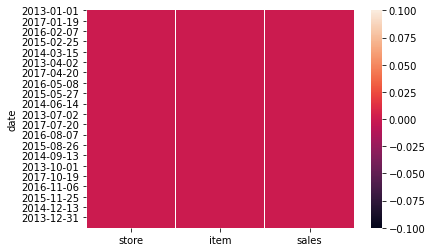

In [26]:
# Identificar visualmente se tem dados faltantes
sns.heatmap(df_train.isnull());

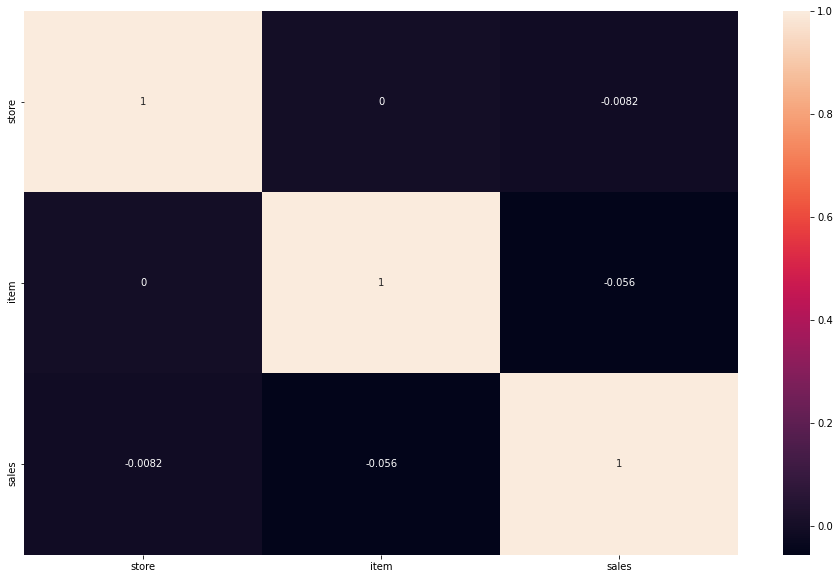

In [27]:
# Correlação entre as variáveis da base de dados
correlations = df_train.corr()
f, ax = plt.subplots(figsize = (16,10))
sns.heatmap(correlations, annot=True);

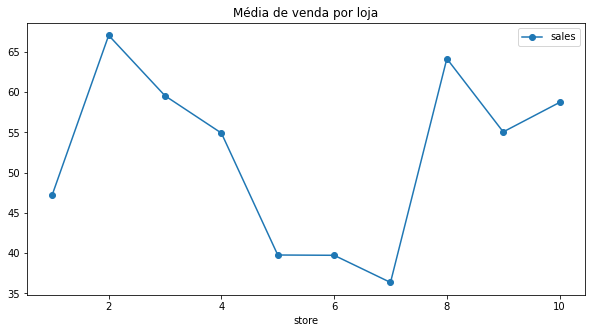

In [28]:
# Plot para saber qual loja vendeu mais durante o ano de 2013 a 2017
# As lojas que mais venderam são a loja 2 e 8
ax = df_train.groupby('store')[['sales']].mean().plot(figsize = (10,5), marker = 'o')
ax.set_title('Média de venda por loja');

In [29]:
# Separação dos dados entre duas lojas para idenficiação da correção entre elas e se a série é estacionário ou não.
df_store_2 = df_train.loc[df_train['store'] == 2]
df_store_8 = df_train.loc[df_train['store'] == 8]
print('Shape Store 2: ',format(df_store_2.shape))
print('Shape Store 8: ',format(df_store_8.shape))

Shape Store 2:  (91300, 3)
Shape Store 8:  (91300, 3)


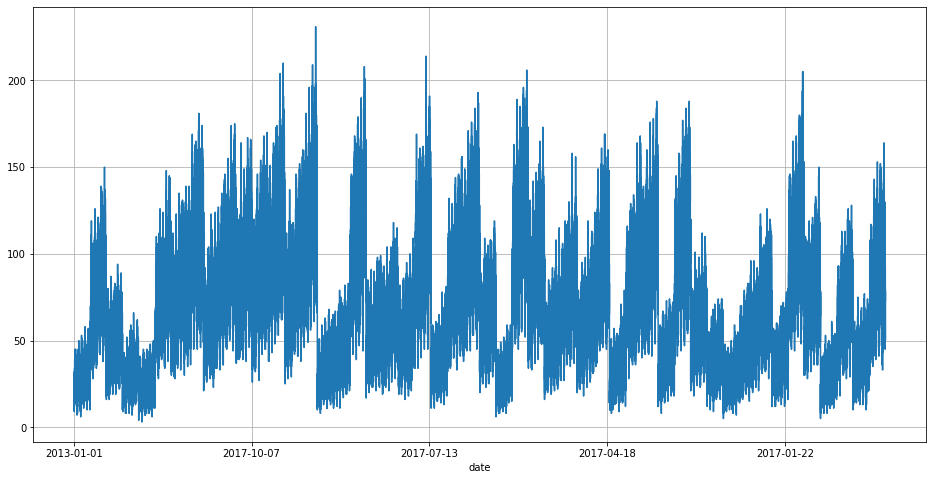

In [30]:
# Plot das vendas da loja 2
df_store_2['sales'].plot(grid = True, figsize= (16,8));

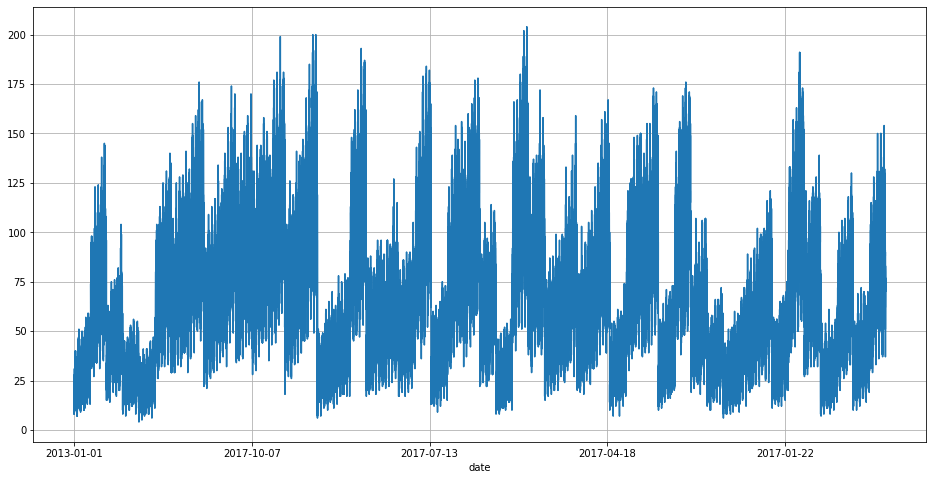

In [31]:
# Plot das vendas da loja 8
df_store_8['sales'].plot(grid = True, figsize= (16,8));

In [32]:
# Correlação entre a loja 2 e loja 8
correlacao = df_store_2['sales'].corr(df_store_8['sales'])
print('Correlação entre loja 2 e loja 8 é de {}%'.format(np.round(correlacao*100)))

Correlação entre loja 2 e loja 8 é de 94.0%


In [33]:
# Autocorrelação da loja 2 com a variável vendas
autocorrelation = df_store_2['sales'].autocorr()
print('A autocorrelação de vendas da loja 2 diária com lag de 1 é de {}%'.format(np.round(autocorrelation*100)))

A autocorrelação de vendas da loja 2 diária com lag de 1 é de 87.0%


In [34]:
# Autocorrelação da loja 8 com a variável vendas
autocorrelation = df_store_8['sales'].autocorr()
print('A autocorrelação de vendas da loja 8 diária com lag de 1 é de {}%'.format(np.round(autocorrelation*100)))

A autocorrelação de vendas da loja 8 diária com lag de 1 é de 87.0%


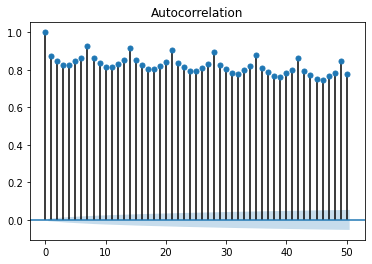

In [35]:
# Plot de Autocorrelação da loja 2 em relação as vendas
plot_acf(df_store_2['sales'], alpha=0.05);

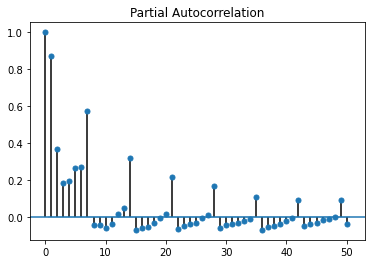

In [36]:
# Plot de Autocorrelação Parcial da loja 2 em relação as vendas
plot_pacf(df_store_2['sales'], alpha=0.05);

In [37]:
# Teste de Dickey Fuller para saber se a série é estacionária
adfinput = adfuller(df_store_2.sales)
adftest = pd.Series(adfinput[0:4], index = ['Teste Estatistico Dickey Fuller', 'Valor-P', 'Lags Usados', 'Número de observações usadas'])

adftest = round(adftest, 4)

for key, value in adfinput[4].items():
    adftest['Valores Críticos (%s)'%key] = value.round(4)

adftest

Teste Estatistico Dickey Fuller      -12.4979
Valor-P                                0.0000
Lags Usados                           66.0000
Número de observações usadas       91233.0000
Valores Críticos (1%)                 -3.4304
Valores Críticos (5%)                 -2.8616
Valores Críticos (10%)                -2.5668
dtype: float64

### * No teste estatístico de Dickey Fuller com a base de 5%, foi comprovada estatiscamente que a série é estacionária devido o p-Valor ser menor que 5%. 

In [38]:
# Visualizando os dados com as novas variáveis
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [11]:
# Criação de features sazonais
df_train['day'] = pd.DatetimeIndex(df_train.index).day
df_train['month'] = pd.DatetimeIndex(df_train.index).month
df_train['year'] = pd.DatetimeIndex(df_train.index).year
df_train['day_of_week'] = pd.DatetimeIndex(df_train.index).dayofweek
df_train['year_of_week'] = pd.DatetimeIndex(df_train.index).dayofyear

In [12]:
# Média de vendas diária
sales_day = df_train.groupby(['day'])['sales'].mean().round(2)
sales_day

day
1     52.16
2     52.29
3     52.31
4     51.82
5     52.49
6     52.13
7     52.04
8     52.28
9     52.21
10    52.31
11    51.85
12    52.45
13    52.12
14    52.18
15    52.22
16    52.27
17    52.36
18    51.79
19    52.57
20    52.17
21    52.18
22    52.29
23    52.19
24    52.26
25    51.84
26    52.60
27    52.10
28    52.11
29    53.02
30    53.40
31    51.61
Name: sales, dtype: float64

In [41]:
# Média de vendas mensais
sales_month = df_train.groupby(['month'])['sales'].mean().round(2)
sales_month

month
1     35.52
2     39.38
3     47.31
4     55.15
5     59.13
6     63.03
7     67.00
8     59.11
9     55.07
10    51.19
11    55.22
12    39.37
Name: sales, dtype: float64

In [42]:
# Média de vendas anuais
sales_year = df_train.groupby(['year'])['sales'].mean().round(2)
sales_year

year
2013    43.51
2014    50.06
2015    52.26
2016    56.60
2017    58.82
Name: sales, dtype: float64

In [43]:
# Total de itens vendidos por ordem descrecente
total_item_sales = df_train.groupby(['item'])['sales'].sum().sort_values(ascending=False)
total_item_sales

item
15    1607442
28    1604713
13    1539621
18    1538876
25    1473334
45    1471467
38    1470330
22    1469971
36    1406548
8     1405108
10    1337133
11    1271925
12    1271534
29    1271240
33    1270183
24    1205975
50    1203009
35    1201541
14    1071531
31    1070845
46    1070764
2     1069564
7     1068777
6     1068281
9      938379
48     937703
43     936635
26     869981
20     867641
32     803107
39     801311
19     736892
30     736554
21     736190
42     669925
3      669087
17     602486
44     536811
49     535663
23     534979
37     534258
40     534094
34     469935
16     468480
27     402628
4      401907
47     401781
41     401759
1      401384
5      335230
Name: sales, dtype: int64

In [44]:
#profile = ProfileReport(df_train, title = 'Store Item Demand', html = {'style':{'full_width':True}})
#profile.to_notebook_iframe()
#profile.to_file(output_file = 'Store Item Demand - Report.html')

# 4. Visualização dos Dados

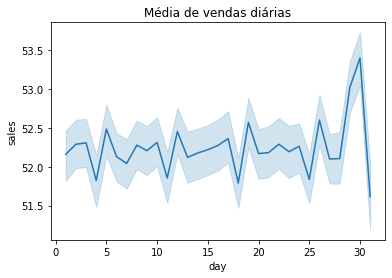

In [57]:
# Plot de média de vendas diárias
sns.lineplot(x= 'day', y='sales', data=df_train).set_title('Média de vendas diárias');

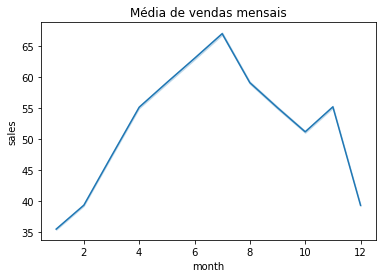

In [45]:
# Plot de média de vendas mensais
sns.lineplot(x= 'month', y='sales', data=df_train).set_title('Média de vendas mensais');

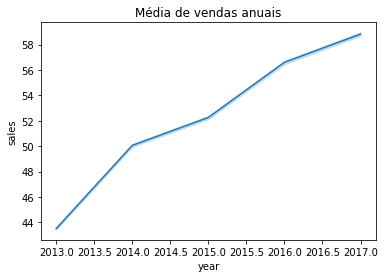

In [46]:
# Plot de média de vendas anuais
sns.lineplot(x= 'year', y='sales', data=df_train).set_title('Média de vendas anuais');

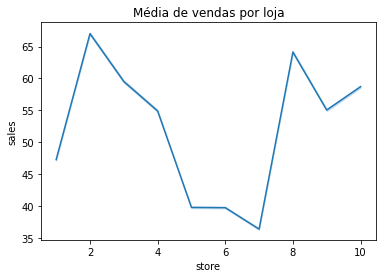

In [47]:
# Plot de média de vendas por loja
sns.lineplot(x= 'store', y='sales', data=df_train).set_title('Média de vendas por loja');

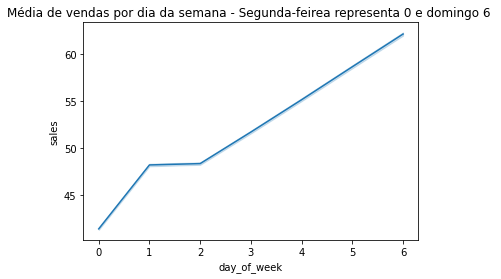

In [48]:
# Plot de média de vendas por dia da semana - Segunda-feirea representa 0 e domingo 6 
sns.lineplot(x= 'day_of_week', y='sales', data=df_train).set_title('Média de vendas por dia da semana - Segunda-feirea representa 0 e domingo 6 ');

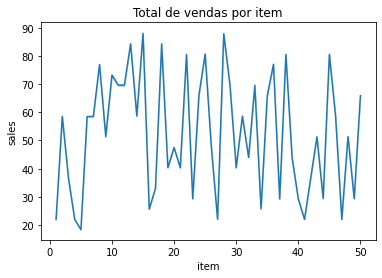

In [49]:
# Plot de total de vendas por item
sns.lineplot(x= 'item', y='sales', data=df_train).set_title('Total de vendas por item');

# 5. Separação dos dados entre treino e validação

In [13]:
train_df = df_train[df_train.index <= '2016-12-31']
test_df = df_train[df_train.index >= '2017-01-01']

X_train = train_df.reset_index().drop(['date', 'sales'], axis =1)
y_train = train_df['sales']
X_test = test_df.reset_index().drop(['date', 'sales'], axis = 1)
y_test = test_df['sales']

In [14]:
# Visualizando o shape de cada base apos separação
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((730500, 7), (730500,), (182500, 7), (182500,))

In [15]:
#Dividindo a base de dados em 75% para treino e 25% para teste
#backtest_size = 0.75
#train_df = df_train.reset_index().drop(['date'],axis=1).loc[0:np.round(df_train.shape[0]*backtest_size),:]
#test_df = df_train.reset_index().drop(['date'],axis=1).loc[np.round(df_train.shape[0]*backtest_size):,:]

In [53]:
#Visualização do shape da base de treino e validação
#train_df.shape, test_df.shape

In [54]:
#Divindindo entre X e y para treino e validação
#X_train = train_df.drop(['sales'], axis=1)
#y_train = train_df['sales'] 
#X_test = test_df.drop(['sales'], axis=1)
#y_test = test_df['sales']

# 6. Importação dos modelos e metricas

In [16]:
!pip install catboost

     |████████████████████████████████| 65.7MB 56kB/s 


In [17]:
# Importação dos modelos e métricas de avaliação
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import median_absolute_error, mean_squared_error

In [18]:
# Função para avaliação do modelo - MAPE (Erro Absoluto Médio Percentual) - Essa métrica mede a média do erro percentual em relação ao valor real com o previsto.
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 7. Modelos que serão usados são XGBoostRegressor, LGBMRegressor e CatBoostRegressor

In [59]:
# Modelo XGBoostRegressor
xgb = XGBRegressor(objective = 'reg:squarederror',random_state=2021)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
print('XGB RMSE: {}'.format(mean_squared_error(y_test, pred_xgb, squared = False)))
print('XGB MAPE: {}'.format(mean_absolute_percentage_error(y_test, pred_xgb)))

# Modelo LightGBMRegressor
lgbm = LGBMRegressor(random_state=2021)
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict(X_test)
print('LGBM RMSE: {}'.format(mean_squared_error(y_test, pred_lgbm, squared = False)))
print('LGBM MAPE: {}'.format(mean_absolute_percentage_error(y_test, pred_lgbm)))


# Modelo CatBoostRegressor
cat = CatBoostRegressor(random_state=2021, verbose=0)
cat.fit(X_train, y_train)
pred_cat = cat.predict(X_test)
print('Cat RMSE: {}'.format(mean_squared_error(y_test, pred_cat, squared = False)))
print('Cat MAPE: {}'.format(mean_absolute_percentage_error(y_test, pred_cat)))


XGB RMSE: 18.64516260720374
XGB MAPE: 27.555711683502587
LGBM RMSE: 9.75088515155836
LGBM MAPE: 14.20028087859044
Cat RMSE: 8.484024257317166
Cat MAPE: 12.529336696478687


### -> O modelo que obteve o melhor resultado foi o CatBoostRegressor com o Cat RMSE: 8.48 e MAPE: 12.52
### -> Nesse problema de negócio optei por usar a métrica MAPE (Erro Absoluto Médio Percentual) que mede a média de erro percentual em relação ao valor real com o valor previsto

# 8. Hiperparâmentro para CatBoostRegressor

In [20]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 5.1MB/s 


In [21]:
# Importação das bibliotecas para execução de hiperparâmentro
from skopt import gp_minimize

In [62]:
# Função que será fornecida ao Bayesian Optimization para encontrar o melhor parâmentro
def train_cat(params):
    iterations = params[0]
    learning_rate = params[1]
    l2_leaf_reg = params[2]
    bagging_temperature = params[3]

    print('Parameters: {} \n'.format(params))
        
    cat = CatBoostRegressor(iterations = iterations, learning_rate = learning_rate, l2_leaf_reg = l2_leaf_reg, bagging_temperature = bagging_temperature,
                            random_state=2021, verbose=0)
    cat.fit(X_train, y_train)
    pred_cat = cat.predict(X_test)
    result = mean_absolute_percentage_error(y_test, pred_cat)
    print('Cat RMSE: {}'.format(mean_squared_error(y_test, pred_cat, squared = False)))
    print('Cat MAPE: {}\n'.format(mean_absolute_percentage_error(y_test, pred_cat)))

  
    return result
          
space_cat = [(500, 3000),#iterations
            (1e-3, 1e-1, 'log-uniform'), #learning_rate
            (1.0, 6.0), #l2_leaf_reg
            (0, 10)]#bagging_temperature


In [63]:
# Bayesian Optimization
result_lgbm_gp = gp_minimize(train_cat, space_cat, random_state= 1, verbose = 1, n_calls=30, n_random_starts=10)
print('Result LGBM GP: {}'.format(result_lgbm_gp.x))

Iteration No: 1 started. Evaluating function at random point.
Parameters: [2993, 0.07330181339535062, 1.6406222396467838, 10] 

Cat RMSE: 8.290443715875089
Cat MAPE: 12.329367109707604

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 311.2741
Function value obtained: 12.3294
Current minimum: 12.3294
Iteration No: 2 started. Evaluating function at random point.
Parameters: [1090, 0.006210998932353835, 2.9395537058100376, 7] 

Cat RMSE: 18.75652114657067
Cat MAPE: 28.652581786129193

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 107.5940
Function value obtained: 28.6526
Current minimum: 12.3294
Iteration No: 3 started. Evaluating function at random point.
Parameters: [2839, 0.049274455443298865, 2.566367584661376, 5] 

Cat RMSE: 8.4396486762197
Cat MAPE: 12.475802284383859

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 289.0459
Function value obtained: 12.4758
Current minimum: 12.3294
Iteration No: 4 started. Evaluating func

### -> Result LGBM GP -> Parameters: iterations = 3000, learning_rate = 0.1, l2_leaf_reg = 6.0, bagging_temperature = 0
### -> O resultado obtidido pelo melhor parâmentro foi de MAPE: 12.2738

In [22]:
# Parametros da Gaussian Processes Optimize
cat = CatBoostRegressor(iterations = 3000, learning_rate = 0.1, l2_leaf_reg = 6.0, bagging_temperature = 0, random_state=2021, verbose=0)
cat.fit(X_train, y_train)
pred_cat = cat.predict(X_test)
result = mean_absolute_percentage_error(y_test, pred_cat)
print('Cat RMSE: {}'.format(mean_squared_error(y_test, pred_cat, squared = False)))
print('Cat MAE: {}\n'.format(mean_absolute_percentage_error(y_test, pred_cat)))
print('Cat MAPE: {}\n'.format(result))

Cat RMSE: 8.2270455954037
Cat MAE: 12.273797654402783

Cat MAPE: 12.273797654402783



# 9. Predição da base de teste

In [23]:
# Carregando dados de teste
test_df = test.copy()

In [24]:
# Criando variáveis sazonais
test_df['day'] = pd.DatetimeIndex(test_df['date']).day
test_df['month'] = pd.DatetimeIndex(test_df['date']).month
test_df['year'] = pd.DatetimeIndex(test_df['date']).year
test_df['day_of_week'] = pd.DatetimeIndex(test_df.index).dayofweek
test_df['year_of_week'] = pd.DatetimeIndex(test_df.index).dayofyear

In [25]:
# Visualizando a base após criação de novas variáveis
test_df.head()

,id,date,store,item,day,month,year,day_of_week,year_of_week
0,0,2018-01-01,1,1,1,1,2018,3,1
1,1,2018-01-02,1,1,2,1,2018,3,1
2,2,2018-01-03,1,1,3,1,2018,3,1
3,3,2018-01-04,1,1,4,1,2018,3,1
4,4,2018-01-05,1,1,5,1,2018,3,1


In [26]:
# Removendo as colunas 'id' e 'date' para entregar ao modelo
test_df = test_df.drop(['id', 'date'], axis = 1)

In [27]:
# Visualizando o shape da base de teste
test_df.shape

(45000, 7)

In [28]:
# Executando o modelo para predição da base de teste
pred = cat.predict(test_df)

In [29]:
# Criando o arquivo com as previsões
sample_submission['sales'] = pred
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

,id,sales
0,0,14.002910
1,1,13.535954
2,2,13.713279
3,3,13.854029
4,4,13.893675


## Outros testes possíveis: 
- Fazer normalização das variáveis
- Testar outros algoritmos

## Obrigado!!!